Aca vamos a hacer la parte de generacion y evaluacion de modelos

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from scripts import mejor_featurer


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,precision_score ,f1_score

In [11]:
df = pd.read_csv("C:/Users/mlard/OneDrive/Escritorio/Mateo/Org de Datos/tp3Github/Org-Datos-Grupo-19/dataset-procesado.csv", index_col=False)

In [12]:
df_trabajo = mejor_featurer.featurizer(df)

-------


In [13]:
df_trabajo.shape

(263965, 138)

In [14]:
df_trabajo.columns

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'D_43', 'D_44',
       'B_4',
       ...
       'D_63_CR', 'D_63_XL', 'D_63_XM', 'D_63_XZ', 'customer_id_repeat_size',
       'd_feats_mean', 's_feats_mean', 'p_feats_mean', 'b_feats_mean',
       'r_feats_mean'],
      dtype='object', length=138)

In [15]:
#Separo en train y test para trabajar los modelos
df_trabajo_x=df_trabajo.drop(['target'], axis='columns', inplace=False)

df_trabajo_y = df_trabajo['target'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x, df_trabajo_y, test_size=0.3, random_state=1)

Modelo Random forest

Buscamos los mejores hiperparametros para el modelo Random forest

In [16]:
rf_cv = RandomForestClassifier(random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5], 
               "max_features":["sqrt", "log2"],
               "min_samples_split" : [2, 5], 
               "n_estimators": [10,50] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1)

In [17]:
gs_fit = gs.fit(X = x_train, y = y_train)
best_params_rfc = gs_fit.best_params_

print(best_params_rfc)

{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}


Predecimos utilizando el mejor modelo q obtuvimos

In [18]:
rfc_best_model = RandomForestClassifier(**best_params_rfc)

In [19]:
model_rfc = rfc_best_model.fit(X = x_train,y = y_train)
y_pred_rfc = model_rfc.predict(x_test)
df_resultados_rfc=pd.DataFrame(zip(y_test,y_pred_rfc),columns=['test','predicted'])

In [51]:
#Para ver a presicion en el conjunto de datos de entrenamiento
# y_train_rfc = model_rfc.predict(x_train)
# tabla=confusion_matrix(y_train, y_train_rfc)

# grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
# plt.show()

In [50]:
# print("precision de entrenamiento : ", accuracy_score(y_train, y_train_rfc))
# print("precicion de test : ", accuracy_score(df_resultados_rfc['test'], df_resultados_rfc['predicted']))
# print('\n No hay overfitting')

In [22]:
df_resultados_rfc.sample(5)

,test,predicted
43267,0,0
35196,0,0
40505,0,0
7008,0,0
75373,1,1


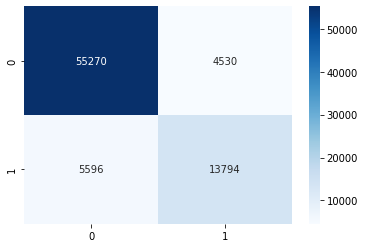

In [24]:
tabla=confusion_matrix(df_resultados_rfc['test'], df_resultados_rfc['predicted'])

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

In [25]:
def results_comparation(df_predict):
    df_predict["success"] = (df_predict["test"] == df_predict["predicted"])
    df_predict["success"].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title("Cantidad de valores predecidos correctamente") 
    plt.show()

    precicion = precision_score(df_predict['test'], df_predict['predicted'])
    f1=f1_score(df_predict['test'], df_predict['predicted'])
    recall = recall_score(df_predict['test'], df_predict['predicted'])
    
    print(f"Precision score: \t{round(precicion,3)}")
    print(f"Recall score: \t\t{round(recall,3)}")
    print(f"F1 score: \t\t{round(f1,3)}")

    accuracy=accuracy_score(df_predict['test'], df_predict['predicted'], normalize=True)
    print("Tiene una accuracy del: " + str(round(accuracy, 3)) + "% como muestra el pie chart")


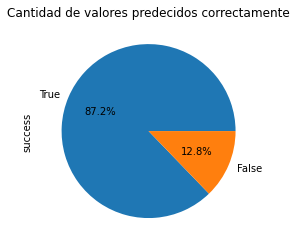

Precision score: 	0.753
Recall score: 		0.711
F1 score: 		0.732
Tiene una accuracy del: 0.872% como muestra el pie chart


In [26]:
results_comparation(df_resultados_rfc)

Modelo XGBoost

In [27]:
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier

In [28]:
# df_featurizado = featurizer_xgb.featurizer(df_trabajo)
df_featurizado = df_trabajo

In [29]:
X_xgb = df_featurizado.drop(axis = 1, columns = ['target'])
y_xgb = df_featurizado.target

features = X_xgb.columns

In [30]:
xgb = XGBClassifier()

In [31]:
#Set hyperparameters dictionary
param_dist = {'n_estimators':[50, 100],
              'max_depth':[5,10],              
              'subsample': [0.5,0.8,1],
              'colsample_bytree': [0.5,0.8,1],              
              'learning_rate':[0.01, 0.1, 0.3]
              }

In [32]:
random_search_xgb = RandomizedSearchCV(xgb,
                                       param_distributions = param_dist,
                                       n_iter = 2,
                                       scoring = 'roc_auc',
                                       cv = 5,
                                       n_jobs = -1,
                                       verbose=5)

In [33]:
%time
random_search_xgb.fit(x_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.8, 1],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [5, 10],
                                        'n_estimators': [50, 100],
                                        'subsample': [0.5, 0.8, 1]},
                   scoring='roc_auc', verbose=5)

In [34]:
params_opt_xgb = random_search_xgb.best_params_

In [35]:
params_opt_xgb

{'subsample': 1,
 'n_estimators': 50,
 'max_depth': 10,
 'learning_rate': 0.1,
 'colsample_bytree': 1}

In [36]:
xgbModelBestParams = XGBClassifier(**params_opt_xgb)

In [38]:
%time
model_xgb = xgbModelBestParams.fit(X = x_train,y = y_train)
y_pred_xgb = model_xgb.predict(x_test)
df_resultados_xgb=pd.DataFrame(zip(y_test,y_pred_xgb),columns=['test','predicted'])

CPU times: total: 0 ns
Wall time: 0 ns


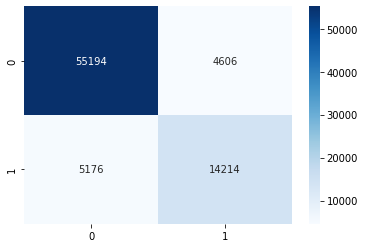

In [39]:
tabla=confusion_matrix(df_resultados_xgb['test'], df_resultados_xgb['predicted'])

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

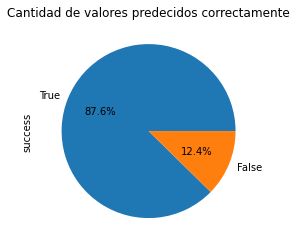

Precision score: 	0.755
Recall score: 		0.733
F1 score: 		0.744
Tiene una accuracy del: 0.876% como muestra el pie chart


In [40]:
results_comparation(df_resultados_xgb)

Suport Vector Machine

Hicimos el analisis del suport vector machine, pero genera muchos problemas y aparte tiene uy poca precicion
(German aca pone lo que hiciste de SVM)

Ensamble de modelos

In [42]:
from sklearn.ensemble import VotingClassifier

In [43]:
vot_clf = VotingClassifier(estimators = [('rnd', rfc_best_model),('xgb', xgbModelBestParams)], voting = 'hard')

In [44]:
vot_clf.fit(x_train, y_train)
pred_vot_clf = vot_clf.predict(x_test)

df_resultados_vot_clf=pd.DataFrame(zip(y_test,pred_vot_clf),columns=['test','predicted'])

Tabla de confusion de test: 


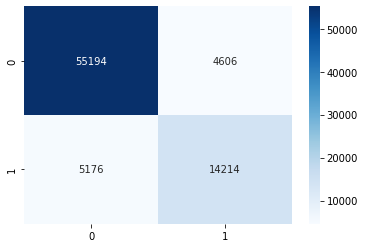

In [45]:
tabla=confusion_matrix(df_resultados_xgb['test'], df_resultados_xgb['predicted'])

print('Tabla de confusion de test: ')

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

Tabla de confusion de entrenamiento: 


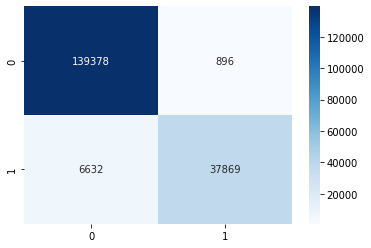

In [46]:
y_train_vot_clf = vot_clf.predict(x_train)
tabla=confusion_matrix(y_train, y_train_vot_clf)
print('Tabla de confusion de entrenamiento: ')
grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

In [49]:
print("Accuracy de entrenamiento : ", accuracy_score(y_train, y_train_vot_clf))
print("Accuracy de test : ", accuracy_score(df_resultados_vot_clf['test'], df_resultados_vot_clf['predicted']))
print('\n')
print('Se puede ver que la precicion para el voting classifier no tiene overfitting ni underfitting')

Accuracy de entrenamiento :  0.9592585577053173
Accuracy de test :  0.8726354337668898


Se puede ver que la precicion para el voting classifier no tiene overfitting ni underfitting


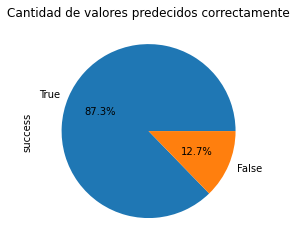

Precision score: 	0.779
Recall score: 		0.671
F1 score: 		0.721
Tiene una accuracy del: 0.873% como muestra el pie chart


In [48]:
results_comparation(df_resultados_vot_clf)

Se puede ver que el voting classifier es el que mas precicion tiene, comparandolos con los modelos RandomForest y XGBoost.

In [56]:
df_resultados_rfc.sample()

,test,predicted,success
69453,0,0,True


In [68]:
df_resultados_rfc['success'][79187]

False

In [67]:
df_resultados_rfc['success']

0         True
1         True
2         True
3         True
4         True
         ...  
79185     True
79186     True
79187    False
79188     True
79189     True
Name: success, Length: 79190, dtype: bool

Ensamble Cascading

In [ ]:
#Forma de un cascading
models = list()
models.append(rfc_best_model)
models.append(xgbModelBestParams)

for type_model in models:
    model = type_model.fit(X = x_train,y = y_train)
    y_pred_model = model.predict(x_test)
    df_resultados_model=pd.DataFrame(zip(y_test,y_pred_rfc),columns=['test','predicted'])

    df_con_casos_no_detectados = pd.DataFrame() #Hay que agregar las filas que no tuvieron exito de prediccion
    for indice in range(df_resultados_model.shape[0]):
        if (df_resultados_model['success'][indice] == False) :
            #De alguna manera hay que conectar el indice del df original con el que da false.
    